In [3]:
# Uncomment to install PyWavelets
!pip3 install PyWavelets
!pip3 install dtcwt

!pip3 install scikit-learn pillow
!pip3 install opencv-python-headless scikit-image matplotlib seaborn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from PIL import Image

# For semantic segmentation
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

from skimage import io, color, img_as_float
from scipy.ndimage import gaussian_filter

import pywt
import dtcwt

In [5]:
# read image of any format - png, bmp, jpg and return the rgb image as numpy array
# normalize the image to [0, 1] range
def read_img(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = img / 255.0
    return img

In [73]:
from skimage.segmentation import slic
from skimage.color import label2rgb

def slic_segmentation(img, n_segments=5, compactness=10, display=False):
    # Determine if the image is grayscale or RGB
    if len(img.shape) == 2:  # Grayscale image
        channel_axis = None
    else:  # RGB image
        channel_axis = -1
    
    segments = slic(img, n_segments=n_segments, compactness=compactness, start_label=1, channel_axis=channel_axis)

    if display:
        segmented_image = label2rgb(segments, img, kind='avg')
        plt.imshow(segmented_image)
        plt.title(f"SLIC Segmentation (n_segments: {n_segments}, compactness: {compactness})")
        plt.axis('off')
        plt.show()

    return segments


def kmeans(img, n_clusters, display=False):
    data = img.reshape((-1, 1))
    H, W = img.shape

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    clusters = kmeans.fit_predict(data)
    clusters = clusters.reshape((H, W))

    if display:
        plt.imshow(clusters, cmap="Spectral")
        plt.title(f"Input Image Segmentation, n_clusters: {n_clusters}")
        plt.axis('off')
        plt.show()

    return clusters


# Semantic Segmentation of the image
def semantic_segmentation(img, n_clusters, display=False):

    # Load a pretrained DeepLabV3 model with ResNet-50 backbone
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    model.eval()  # Set the model to evaluation mode

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the preprocessing
    input_tensor = preprocess(img).float()
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    with torch.no_grad():
        output = model(input_batch)["out"][0]  # Shape: [21, H, W] for 21 classes   

    # Get the predicted class for each pixel
    segmentation = torch.argmax(output, dim=0).byte().cpu().numpy()

    if display:
        plt.imshow(segmentation)
        plt.title("Segmentation Mask")
        plt.axis("off")
        plt.show()

    return segmentation # THINK: Is it too many clusters?

# from skimage.morphology import opening, closing, disk
# from skimage import io, color, img_as_float, morphology
# from scipy.ndimage import gaussian_filter
# from scipy import ndimage as ndi
# def simple_segmentation(image, n_clusters=5, feature_space='rgb', spatial_weight=0.6, smoothing_sigma=1,display=False):
#     """
#     Perform simple image segmentation using K-means clustering.

#     Parameters:
#     - image: Input image as a NumPy array.
#     - n_clusters: The desired number of clusters (segments).
#     - feature_space: The color space to use ('rgb' or 'lab').

#     Returns:
#     - labels: A 2D array of the same height and width as the image, containing the segment labels.
#     """
#     # Convert image to float representation
#     image = img_as_float(image)
#     h, w, c = image.shape

#     # Apply image smoothing to reduce noise
#     smoothed_image = gaussian_filter(image, sigma=(smoothing_sigma, smoothing_sigma, 0))

#     # Choose feature space
#     if feature_space == 'lab':
#         # Convert to Lab color space for better perceptual similarity
#         image_feats = color.rgb2lab(smoothed_image)
#     else:
#         # Use RGB color space
#         image_feats = smoothed_image

#     # Reshape the image to a 2D array of pixels and color features
#     X = image_feats.reshape((-1, c))

#     # Perform K-means clustering
#     print("Performing K-means clustering...")
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(X)
#     labels = kmeans.labels_

#     # Reshape labels back to image dimensions
#     labels = labels.reshape((h, w))

#     # Apply improved morphological operations to clean up small regions
#     selem = morphology.disk(5)
#     labels_cleaned = np.zeros_like(labels)
#     min_size = 500  # Adjust this value based on image size

#     for i in range(n_clusters):
#         mask = (labels == i).astype(np.bool_)
#         mask_filled = ndi.binary_fill_holes(mask)
#         mask_cleaned = morphology.remove_small_objects(mask_filled, min_size=min_size)
#         mask_smooth = morphology.closing(mask_cleaned, selem)
#         mask_smooth = morphology.opening(mask_smooth, selem)
#         labels_cleaned[mask_smooth] = i

#     if display:
#         plt.imshow(labels_cleaned, cmap='tab20')
#         plt.axis('off')
#         plt.title('Segmentation Result')
#         plt.show()

#     return labels_cleaned


In [89]:
# simple segmentation with options

from skimage.morphology import opening, closing, disk
from skimage import io, color, img_as_float, morphology
from scipy.ndimage import gaussian_filter
from scipy import ndimage as ndi
from skimage.segmentation import slic
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


def simple_segmentation(image, n_clusters=10, feature_space='rgb', smoothing_sigma=1,
                        method='kmeans', slic_segments=10, slic_compactness=10, display=False):
    """
    Perform simple image segmentation using K-means clustering or SLIC.

    Parameters:
    - image: Input image as a NumPy array.
    - n_clusters: The desired number of clusters (segments) for K-means.
    - feature_space: The color space to use ('rgb' or 'lab').
    - spatial_weight: Weight for spatial features (used in K-means, not applicable for SLIC).
    - smoothing_sigma: Sigma for Gaussian smoothing.
    - method: Segmentation method ('kmeans' or 'slic').
    - slic_segments: Number of segments for SLIC.
    - slic_compactness: Compactness parameter for SLIC.
    - display: Whether to display the segmented image.

    Returns:
    - labels: A 2D array of the same height and width as the image, containing the segment labels.
    """
    # Convert image to float representation
    image = img_as_float(image)
    h, w, c = image.shape

    # Apply image smoothing to reduce noise
    smoothed_image = gaussian_filter(image, sigma=(smoothing_sigma, smoothing_sigma, 0))

    if method == 'kmeans':
        # Choose feature space for K-means
        if feature_space == 'lab':
            # Convert to Lab color space for better perceptual similarity
            image_feats = color.rgb2lab(smoothed_image)
        else:
            # Use RGB color space
            image_feats = smoothed_image

        # Reshape the image to a 2D array of pixels and color features
        X = image_feats.reshape((-1, c))

        # Perform K-means clustering
        print("Performing K-means clustering...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_

        # Reshape labels back to image dimensions
        labels = labels.reshape((h, w))

    elif method == 'slic':
        print("Performing SLIC segmentation...")
        labels = slic(smoothed_image, n_segments=slic_segments, compactness=slic_compactness, start_label=1)

    else:
        raise ValueError("Unsupported method. Use 'kmeans' or 'slic'.")

    # Apply morphological operations to clean up small regions
    selem = morphology.disk(5)
    labels_cleaned = np.zeros_like(labels)
    min_size = 500  # Adjust this value based on image size

    for i in range(np.max(labels) + 1):
        mask = (labels == i).astype(np.bool_)
        mask_filled = ndi.binary_fill_holes(mask)
        mask_cleaned = morphology.remove_small_objects(mask_filled, min_size=min_size)
        mask_smooth = morphology.closing(mask_cleaned, selem)
        mask_smooth = morphology.opening(mask_smooth, selem)
        labels_cleaned[mask_smooth] = i

    if display:
        if method == 'kmeans':
            plt.imshow(labels_cleaned, cmap='tab20')
        else:  # SLIC
            segmented_image = label2rgb(labels_cleaned, image, kind='avg')
            plt.imshow(segmented_image)
        plt.axis('off')
        plt.title(f'Segmentation Result ({method.upper()})')
        plt.show()

    return labels_cleaned


In [7]:
# Performs Log Normalization and z-tranforms and clips data [-1, 2] range
def normalize_coeffs(bands):
    reals = []
    imags = []
    for band in range(bands.shape[-1]):
        real_coeffs = bands[:, :, band].real
        imag_coeffs = bands[:, :, band].imag

        # Normalize
        # Log (1+x) transform
        eps = 1e-8
        real_coeffs = np.log10((real_coeffs) + abs(real_coeffs.min()) + eps)
        imag_coeffs = np.log10((imag_coeffs) + abs(imag_coeffs.min()) + eps)

        # Z-Scaling
        real_coeffs = (real_coeffs - real_coeffs.mean()) / (real_coeffs.std() + 1e-8)
        imag_coeffs = (imag_coeffs - imag_coeffs.mean()) / (imag_coeffs.std() + 1e-8)

        reals.append(real_coeffs)
        imags.append(imag_coeffs)

    return np.asarray(reals), np.asarray(imags)

def display_wavelet_coeffs(reals, imags, display=False):
    # Clip the data to [-1, 2] range
    reals = np.clip(reals, -1, 2)
    imags = np.clip(imags, -1, 2)
    if display:
        plt.figure(figsize=(12, 4))
        for i, data in enumerate(zip(reals, imags)):
            real, imag = data

            plt.subplot(2, 6, i + 1)
            plt.imshow(real, cmap="Spectral")
            plt.title(f"Real, Band{i+1}")
            plt.axis('off')

            plt.subplot(2, 6, i + 7)
            plt.imshow(imag, cmap="Spectral")
            plt.title(f"Imag, Band{i+1}")
            plt.axis('off')

        plt.suptitle("Level 1, Real and Imaginary Bands 1-6")
        plt.show()

def get_patch_mean_variance(band, patch_size):
    H, W = band.shape
    patch_means = []
    for h in range(0, H, patch_size):
        for w in range(0, W, patch_size):
            patch = band[h:h+patch_size, w:w+patch_size]
            patch_means.append(np.mean(patch))

    var = np.var(patch_means)
    return var

def get_band_variance(mask, reals, imags, patch_size=16):
    real_var = []
    imag_var = []
    for real, imag in zip(reals, imags):
        # Real first
        band = mask * real
        real_var.append(get_patch_mean_variance(band, patch_size))
        
        # Imag
        band = mask * imag
        imag_var.append(get_patch_mean_variance(band, patch_size))

    return np.asarray(real_var), np.asarray(imag_var)

def compute_threshold_dynamic(real_coeffs, imag_coeffs):
    var_reals, var_imag = get_band_variance(np.ones_like(real_coeffs[0]), real_coeffs, imag_coeffs)
    var = np.concatenate((var_imag, var_reals))
    var.sort()

    return var[-5]

def compute_threshold_dynamic(real_coeffs, imag_coeffs, percentile=15):
    # Calculate variances for all bands
    var_reals, var_imags = get_band_variance(np.ones_like(real_coeffs[0]), real_coeffs, imag_coeffs)
    var = np.concatenate((var_imags, var_reals))  # Combine real and imaginary variances

    # Compute threshold as the percentile of variances
    threshold = np.percentile(var, percentile)
    
    return threshold


In [8]:
# Return the coeffs of the DT-CWT transform
def wavelet_dtcwt(img):
    assert len(img.shape) == 2, "Not a grayscale image"

    # Initialize the DTCWT transform
    transform = dtcwt.Transform2d()

    # Perform the DTCWT on the image with only 1 level
    coeffs = transform.forward(img, nlevels=1)
    return coeffs.highpasses[0]

def wavelet_general(img, wavelet_type='haar'):

    if wavelet_type == 'dtcwt':
        return wavelet_dtcwt(img)

    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet_type)
    print(LH.shape)
    H, W = LH.shape

    coeffs = np.zeros((H, W, 3))
    coeffs[:, :, 0] = LH
    coeffs[:, :, 1] = HL
    coeffs[:, :, 2] = HH

    return coeffs

In [9]:
def noise_zero(img):
    return np.zeros_like(img)

In [10]:
def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        print('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        print('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

In [11]:
# normalise the output between [0,1]
def small_median_filter_residue(band, kernel_size):
    median_blur = cv2.medianBlur(band, ksize=kernel_size)
    first_diff = band - median_blur
    second_diff = cv2.medianBlur(first_diff, ksize=kernel_size)
    band = band - second_diff
    band = (band - band.min()) / (band.max() - band.min())
    return band

def wiener_filter(band, kernel_size=3, noise_variance=0.1):
    local_mean = cv2.blur(band, (kernel_size, kernel_size))
    local_variance = cv2.blur((band - local_mean) ** 2, (kernel_size, kernel_size))
    wiener_filtered = local_mean + (local_variance - noise_variance) / (local_variance + 1e-8) * (band - local_mean)
    return np.clip(wiener_filtered, 0, 1)  # Clipping to avoid overflow

from skimage import restoration
from scipy.signal import convolve2d

# normalise the output between [0,1]
def wiener_filter_updated(img):
    psf = np.ones((5, 5)) / 25
    img = convolve2d(img, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)
    deconvolved_img = (deconvolved_img - deconvolved_img.min()) / (deconvolved_img.max() - deconvolved_img.min())
    return deconvolved_img

# normalise the output between [0,1]
def median_modified_wiener_filter(band, kernel_size=3, noise_variance=0.1):
    # Step 1: Apply median filter
    median_filtered = cv2.medianBlur(band, kernel_size)
    # Step 2: Apply Wiener filter to median-filtered band
    # wiener_filtered = wiener_filter(median_filtered, kernel_size, noise_variance)
    wiener_filtered = wiener_filter_updated(median_filtered)
    wiener_filtered = (wiener_filtered - wiener_filtered.min()) / (wiener_filtered.max() - wiener_filtered.min())
    return wiener_filtered

In [146]:
def get_mask_from_releavant_bands(bands, kernel_size, display=False):
    if len(bands) == 0:
        print("No bands available. Adjust threshold maybe.")
        return 0

    final_mask = np.zeros_like(bands[0])
    for band in bands:
        band = band.astype(np.float32)
        median_filtered = cv2.medianBlur(band, ksize=kernel_size)
        
        # normalise the output between [0,1]
        median_filtered = (median_filtered - median_filtered.min()) / (median_filtered.max() - median_filtered.min())

        smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
        # wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
        wiener_filtered = wiener_filter_updated(band)
        median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

        # filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]
        filters = [wiener_filtered]

        #display filtered images
        if display:
            plt.figure(figsize=(12, 4))
            for i, filter_img in enumerate(filters):
                filter_img_clipped = np.clip(filter_img, -1, 2)
                plt.subplot(1, 4, i + 1)
                plt.imshow(filter_img_clipped, cmap="Spectral")
                plt.title(f"Filter {i+1}")
                plt.axis('off')
                plt.colorbar()
            plt.suptitle("Filtered Images")
            plt.show()

        # noise estimate for the band 
        # largest_noise_estimate = noise_estimate(band, 8)

        avg_filter = np.zeros_like(median_filtered)
        for filter_img in filters:
            avg_filter += filter_img
        avg_filter /= len(filters)
        if display:
            avg_filter_clipped = np.clip(avg_filter, -1, 2)
            plt.imshow(avg_filter_clipped, cmap="Spectral")
            plt.title("Average Filter")
            plt.colorbar()
            plt.axis('off')
            plt.show()


        for filter_img in [avg_filter]:
            filtered_clusters = kmeans(filter_img, n_clusters=4, display=False)
            # filtered_clusters = segments
            # filtered_clusters = slic_segmentation(filter_img, n_segments=5, compactness=10, display=False)
            largest_noise_clus = None
            largest_noise_estimate = 1e-32
            # largest_noise_estimate = 1e-15

            # max_noise = -1e32
            for clus in list(np.unique(filtered_clusters)):
            #     internal_mask = (filtered_clusters == clus).astype(np.int8)
            #     noise = (band - filter_img) * internal_mask
            #     noise_range = noise.max() - noise.min()
                noise_est = noise_estimate(band, 8)
                if noise_est > largest_noise_estimate:
                    largest_noise_clus = clus
                    largest_noise_estimate = noise_est

            assert largest_noise_clus != None

            # display the lowest noise cluster
            if display:
                plt.imshow(filtered_clusters == largest_noise_clus)
                plt.title("Largest Noise Cluster")
                plt.colorbar()
                plt.axis('off')
                plt.show()

            final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

    return final_mask

In [153]:
#clusterwise

def detect_inpainting(
    file_path,
    wavelet_type,
    loaded_detections,
    noise_func,
    patch_size=16,
    var_threshold='dynamic',
    kernel_size=3,
    display=False
    
):
    # Read Image
    img = read_img(file_path)
    
    # Display Input Image
    if display:
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()
        print("Image Shape ", img.shape)

    # Convert to grayscale
    gray_img = img.mean(axis=2)
    H, W = gray_img.shape

    masks = loaded_detections["masks"]
    scores = loaded_detections["scores"]
    bounding_boxes = loaded_detections["bounding_boxes"]

    segments = np.zeros((H, W), dtype=int)

    for i, mask in enumerate(masks):
        # Ensure the mask is binary and within bounds
        mask = mask.astype(int)

        # Add the mask to the `segments` array with a unique label
        segments[mask == 1] = i + 1  # Use `i + 1` to avoid overlapping with background (0)

    # Display Gray Image
    if display:
        plt.imshow(gray_img, cmap="gray")
        plt.axis('off')
        plt.title("Gray Image")
        plt.show()

    # Perform segmentation
    clusters = segments
    # clusters = simple_segmentation(img, n_clusters=4, feature_space='rgb', method='kmeans', display=display, smoothing_sigma=1)

    # Adjust segmentation mask size
    clusters = clusters[::2, ::2]

    # Add Noise
    noise = noise_func(gray_img)
    gray_img += noise

    # DTCWT on grayscale image
    wavelet_coeffs = wavelet_general(gray_img, wavelet_type=wavelet_type) 
    print("Wavelet Coeffs Shape: ", wavelet_coeffs.shape)

    # Normalize coefficients
    real_coeffs, imag_coeffs = normalize_coeffs(wavelet_coeffs)

    # Display Normalized Wavelet Coefficients
    display_wavelet_coeffs(real_coeffs, imag_coeffs, display=display)

    final_mask = np.zeros_like(real_coeffs[0])  # Initialize final mask

    # Loop through clusters
    for cluster in list(np.unique(clusters)):
        mask = (clusters == cluster).astype(np.int8)

        # Display mask
        if display:
            plt.imshow(mask, cmap="gray")
            plt.axis('off')
            plt.title("Mask Image")
            plt.show()

        # Compute variances for the cluster
        real_vars, imag_vars = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size=patch_size)
        print("Real Vars: ", real_vars)
        print("Imag Vars: ", imag_vars)

        real_vars = (real_vars - real_vars.min()) / (real_vars.max() - real_vars.min() + 1e-8)
        imag_vars = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min() + 1e-8)

        # Compute dynamic threshold for this cluster
        if var_threshold == 'dynamic':
            combined_vars = np.concatenate((real_vars, imag_vars))
            cluster_threshold = np.percentile(combined_vars, 99)  # Use 95th percentile, or modify as needed
            print(f"Dynamic threshold for cluster {cluster}: {cluster_threshold}")
        else:
            cluster_threshold = var_threshold

        # Select relevant bands based on the cluster-specific threshold
        relavant_band_real = []
        relavant_band_imag = []

        print("Picked Bands:")
        for i in range(len(real_vars)):
            rvar, ivar = real_vars[i], imag_vars[i]

            if rvar >= cluster_threshold:
                relavant_band_real.append(mask * real_coeffs[i])
                print(f"Real {i + 1}")

            if ivar >= cluster_threshold:
                relavant_band_imag.append(mask * imag_coeffs[i])
                print(f"Imag {i + 1}")

        # Add masks from relevant bands
        final_mask += get_mask_from_releavant_bands(relavant_band_real, kernel_size=kernel_size, display=display)
        final_mask += get_mask_from_releavant_bands(relavant_band_imag, kernel_size=kernel_size, display=display)


        # final_mask += get_mask_from_relevant_bands(relavant_band_real, kernel_size=kernel_size, display=display)
        # final_mask += get_mask_from_relevant_bands(relavant_band_imag, kernel_size=kernel_size, display=display)

    # Display Final Mask
    if display:    
        plt.imshow(final_mask, cmap="gray")
        plt.axis('off')
        plt.title("Final Mask")
        plt.show()

    return final_mask


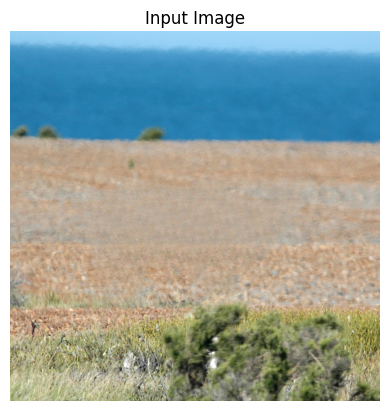

Image Shape  (1023, 1024, 3)


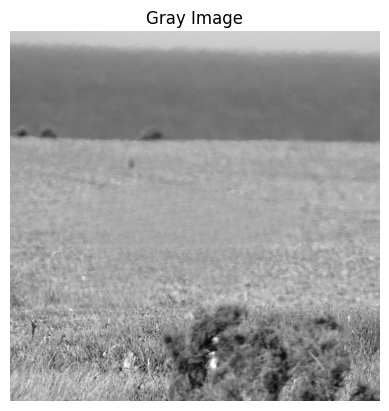

Wavelet Coeffs Shape:  (512, 512, 6)


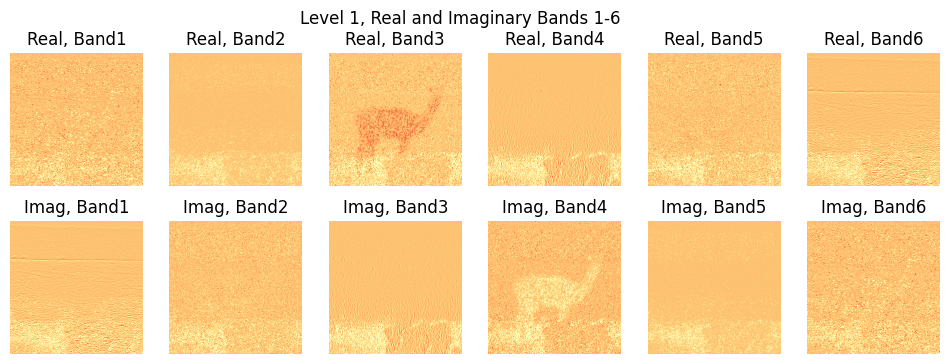

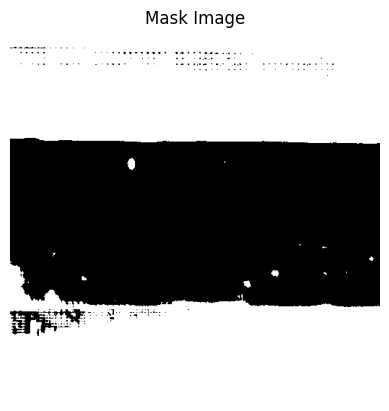

Real Vars:  [0.00045964 0.00104136 0.00312069 0.00295009 0.00146656 0.00093012]
Imag Vars:  [0.00138429 0.00118732 0.00294225 0.00280843 0.00123003 0.0005649 ]
Dynamic threshold for cluster 0: 0.9999961927675839
Picked Bands:
Real 3


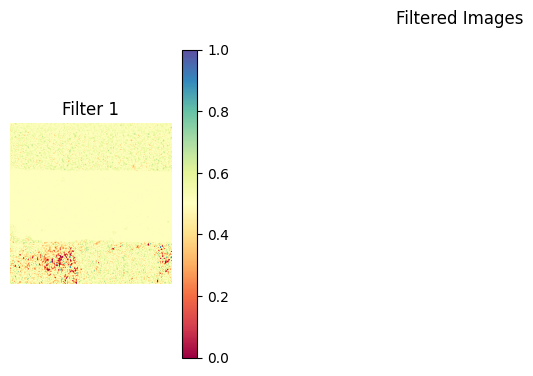

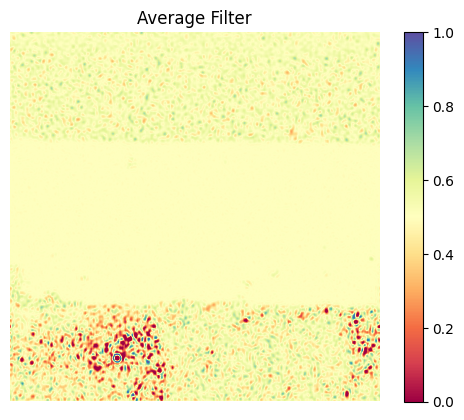

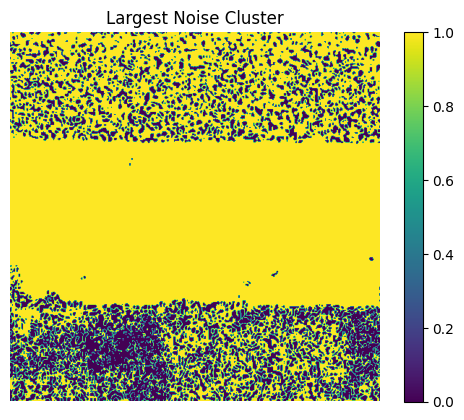

No bands available. Adjust threshold maybe.


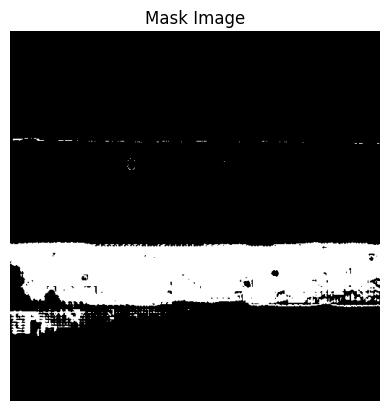

Real Vars:  [2.83486330e-05 1.39490945e-05 5.31578464e-04 4.80435597e-05
 3.36858178e-05 2.47147623e-05]
Imag Vars:  [2.97678018e-05 4.52510996e-05 4.40735318e-05 7.11752291e-04
 1.73044038e-05 3.26306845e-05]
Dynamic threshold for cluster 1: 0.9999850592165193
Picked Bands:
Imag 4
No bands available. Adjust threshold maybe.


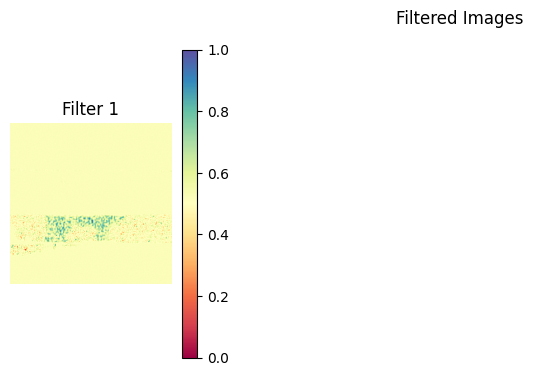

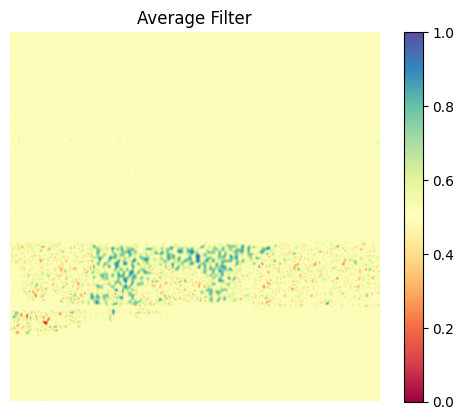

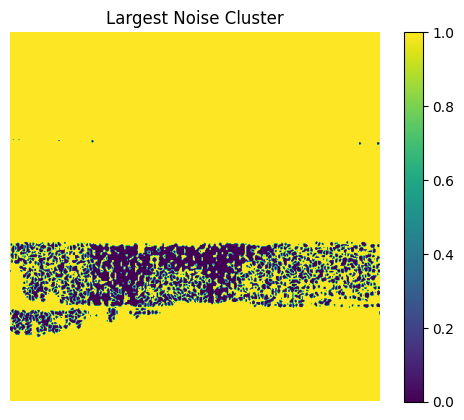

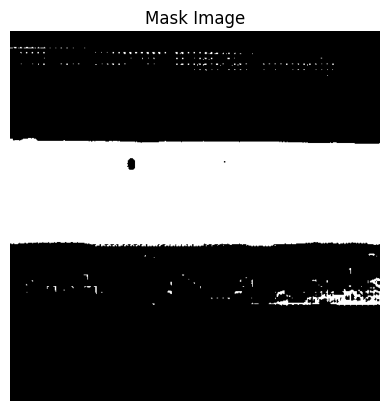

Real Vars:  [1.02776872e-04 6.20031315e-05 8.84655325e-04 1.18153497e-04
 9.38140908e-05 6.57893755e-05]
Imag Vars:  [9.76093565e-05 7.32264633e-05 1.10592364e-04 1.36459857e-03
 6.39884103e-05 1.24299051e-04]
Dynamic threshold for cluster 2: 0.9999918199881583
Picked Bands:
Imag 4
No bands available. Adjust threshold maybe.


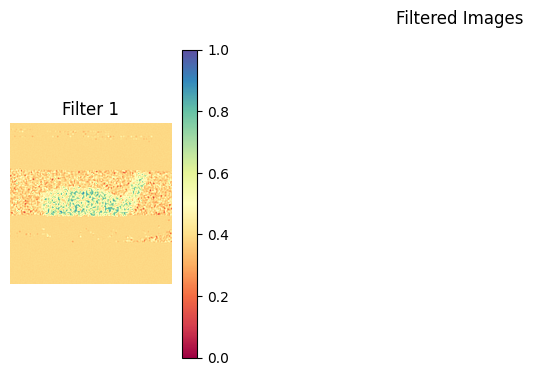

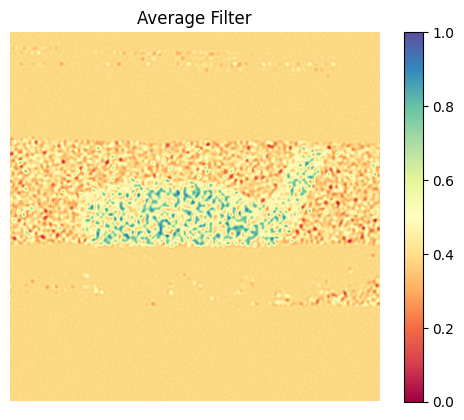

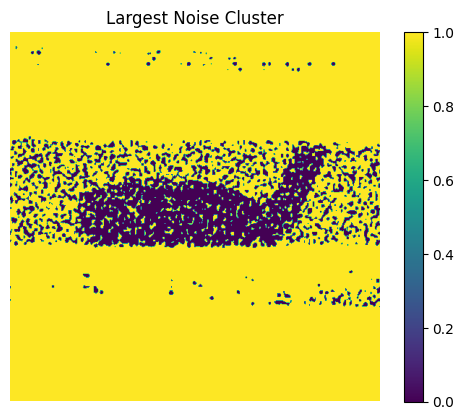

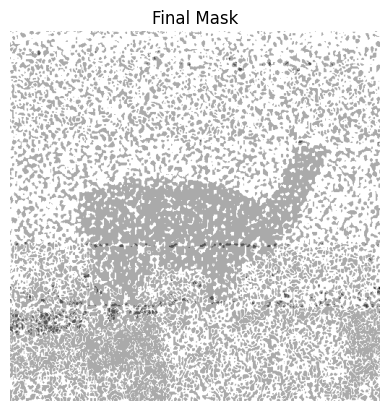

In [154]:
# path = '/mntdata/avanti/all lama/97c4c3df2b76945f_altered.bmp'
# path = '/mntdata/avanti/project/ece251c/md_0_paper_lama.bmp'

import pickle


path = '/mntdata/avanti/project/ece251c/md_0_paper_lama.bmp'

with open("/mntdata/filtered.pkl", "rb") as f:
    loaded_detections = pickle.load(f)

final_mask = detect_inpainting(file_path=path, wavelet_type='dtcwt', noise_func=noise_zero, kernel_size=5, patch_size=64, var_threshold='dynamic', display=True, loaded_detections = loaded_detections)

In [152]:

for key, value in loaded_detections.items():
    print(f"Key: {key}, Type: {type(value)}")

Key: masks, Type: <class 'list'>
Key: scores, Type: <class 'list'>
Key: bounding_boxes, Type: <class 'list'>


[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 ...

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]]
Ground Truth Mask Shape:  (512, 512)


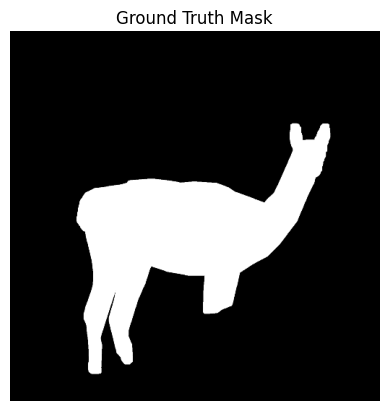

NameError: name 'morphed_mask' is not defined

In [16]:
def calculate_metrics(gt_mask, pred_mask, threshold=0.5):
    # Convert predicted mask to numpy array
    pred_mask = np.array(pred_mask)
    
    # Ensure both masks have the same shape
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Ground truth and predicted masks must have the same shape.")
    
    # Convert masks to boolean arrays
    gt_mask_bool = gt_mask > threshold
    pred_mask_bool = pred_mask > threshold
    
    # Calculate intersection and union
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool)
    union = np.logical_or(gt_mask_bool, pred_mask_bool)
    
    # Calculate IoU
    union_sum = np.sum(union)
    iou = np.sum(intersection) / union_sum if union_sum > 0 else 1.0
    
    # Calculate accuracy
    accuracy = np.mean(gt_mask_bool == pred_mask_bool)
    
    # Calculate precision and recall
    true_positive = np.sum(intersection)
    false_positive = np.sum(np.logical_and(~gt_mask_bool, pred_mask_bool))
    false_negative = np.sum(np.logical_and(gt_mask_bool, ~pred_mask_bool))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 1.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 1.0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "accuracy": accuracy,
        "iou": iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

# get the ground truth mask
gt_mask = read_img("/mntdata/avanti/project/ece251c/md_0_paper_mask.png")
print(gt_mask)

# downsample the ground truth mask to match the predicted mask size
gt_mask = gt_mask[::2, ::2]
gt_mask = gt_mask.mean(axis=2)

print("Ground Truth Mask Shape: ", gt_mask.shape)

# print the ground truth mask
plt.imshow(gt_mask, cmap="gray")
plt.axis('off')
plt.title("Ground Truth Mask")
plt.show()

# calculate the quality metrics
metrics = calculate_metrics(gt_mask, morphed_mask)
print(metrics)
# print(f"Accuracy: {accuracy:.4f}")
# print(f"IoU: {iou:.4f}")


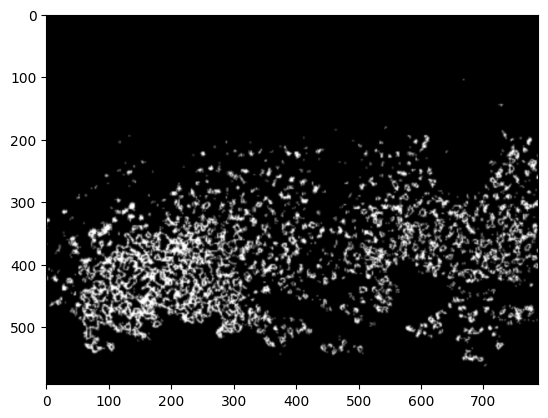

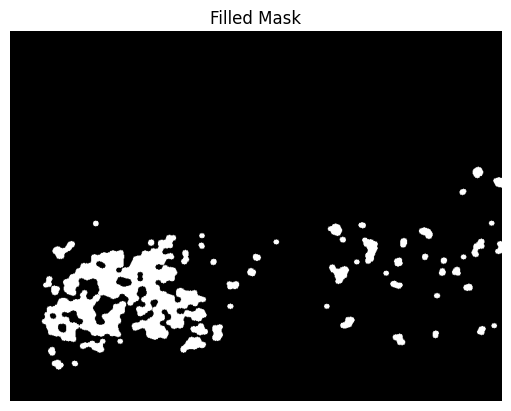

In [84]:
def morph_mask(mask):
    mask = mask.astype(np.uint8) 
    mask = (mask > 125) 
    mask = mask.astype(np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)))

    # do opening and closing to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)))

    # remove big connected components from the white mask
    # mask = morphology.remove_small_objects(mask > 0, min_size=4, connectivity=1).astype(np.uint8)

    # invert the mask and remove small connected components from the black mask and invert it back
    mask = 1 - mask
    # mask = morphology.remove_small_objects(mask > 0, min_size=12, connectivity=1).astype(np.uint8)
    mask = 1 - mask

    # open the mask to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)))

    return mask

tester = cv2.imread('/mntdata/test2.png',0)
plt.imshow(tester, cmap="gray")
plt.show()

mask = morph_mask(tester)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.title("Filled Mask")
plt.show()